In [14]:
import maze as mz
from importlib import reload
reload(mz)
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import copy

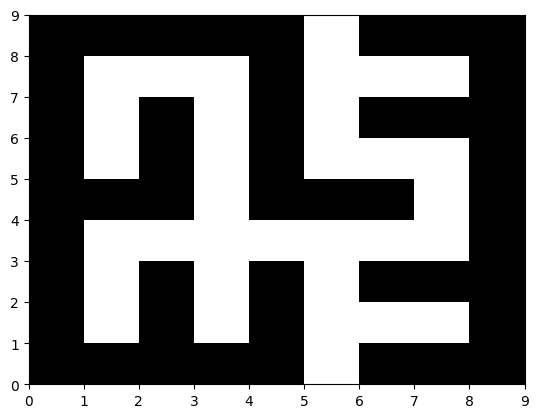

In [2]:
training_maze = mz.Maze((9,9), 11)
training_maze.generate()
training_maze.squares[training_maze.squares != 0] = 1
training_maze.plot()

In [3]:
# Réseau de neurones pour approximer Q(s,a)
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 49)
        self.fc2 = nn.Linear(49, 49)
        self.fc3 = nn.Linear(49, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


In [4]:
def select_action(state, epsilon, model, action_size):
    if random.random() < epsilon:
        return random.randint(0, action_size - 1)
    else:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = model(state_tensor)
        return torch.argmax(q_values).item()

In [15]:
def train_from_memory(model, target_model, memory, batch_size, gamma, optimizer):
    if len(memory) < batch_size*2:
        return

    batch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.tensor(states, dtype=torch.float32).to(device)
    actions = torch.tensor(actions).unsqueeze(1).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device)
    next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
    dones = torch.tensor(dones, dtype=torch.bool).unsqueeze(1).to(device)

    # Q(s, a)
    q_values = model(states).gather(1, actions)

    # max_a' Q(s', a')
    with torch.no_grad():
        q_next = target_model(next_states).max(1)[0].unsqueeze(1)
        q_target = rewards + (1 - dones.float()) * gamma * q_next

    loss = nn.MSELoss()(q_values, q_target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [74]:
class Env:
    def __init__(self,maze):
        self.maze = maze.squares
        self.start = maze.start
        self.goal = maze.end
        self.agent_pos = self.start
        self.visited = {}

    def reset(self):
        self.agent_pos = self.start
        self.visited = {}
        return self.get_state()
        

    def step(self, action):
        x, y = self.agent_pos
        
        dx, dy = [(0, -1), (0, 1), (-1, 0), (1, 0)][action]  # up, down, left, right
        nx, ny = x + dx, y + dy
        # Mur ou hors limite
        if (nx < 0 or ny < 0 or ny >= self.maze.shape[1] or nx >= self.maze.shape[0] 
            or self.maze[nx,ny] == 0):
            reward = -10
            done = False
            if (x, y) not in self.visited:
                self.visited[(x,y)] = 0
            else:
                self.visited[(x,y)] += 1
            return self.get_state(), reward, done

        self.agent_pos = (nx, ny)
        if (nx, ny) not in self.visited:
            self.visited[(nx,ny)] = 0
        else:
            self.visited[(nx,ny)] += 1
        if self.agent_pos == self.goal:
            reward = 30
            done = True
        else:
            dist_from_start = abs(self.start[0] - x)+ abs(self.start[1] - y)
            reward = min(-self.visited[(nx,ny)]*0.1 + 0.1*dist_from_start, 5)
            reward = max(reward, -5)
            done = False

        return self.get_state(), reward, done

    def get_state(self):
        # Exemple : vecteur d’état = [x, y, dx, dy]
        x, y = self.agent_pos
        gx, gy = self.goal
        xo = x - 1
        xe = x + 1
        yn = y - 1
        ys = y + 1
        if x == 0:
            xo = x
        if x == self.maze.shape[0] - 1:
            xe = x
        if y == 0:
            yn = y
        if y == self.maze.shape[1] - 1:
            ys = y
            
        return np.array([x, y, self.maze[x,yn], self.maze[x,ys], 
                         self.maze[xo,y], self.maze[xe,y],
                         abs(self.start[0] - x) + abs(self.start[1] - y)], 
                         dtype=np.float32)

from IPython.display import clear_output
env = Env(training_maze)
memory = deque(maxlen=1000)
batch_size = 40
# Hyperparamètres
gamma = 0.99
epsilon = 0.9
epsilon_min = 0.01
epsilon_decay = 0.9
learning_rate = 0.0001
num_episodes = 10000

# Initialisation du réseau
state_size = 7  # à définir selon ton vecteur d'état
action_size = 4   # haut, bas, gauche, droite

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DQN(state_size, action_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()
rewards = []
target_model = copy.deepcopy(model)
n_done = 0
for episode in range(num_episodes):
    if episode % 50 == 0:
        target_model.load_state_dict(model.state_dict())
    if (episode+1) % batch_size == 0:
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
    state = env.reset()
    done = False
    total_reward = 0
    n_action = 0
    clear_output(wait=True)
    while not done and n_action < 200:
        action = select_action(state, epsilon, model, action_size)
        next_state, reward, done = env.step(action)
        memory.append((state, action, reward, next_state, done))
        if done:
            n_done += 1
        state = next_state
        total_reward += reward
        train_from_memory(model, target_model, memory, batch_size, gamma, optimizer)
        n_action += 1
    
    # Diminution de epsilon
    # epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards.append(total_reward)
    print(f"Épisode {episode+1}, récompense: {total_reward}, epsilon: {epsilon:.3f}")

KeyboardInterrupt: 

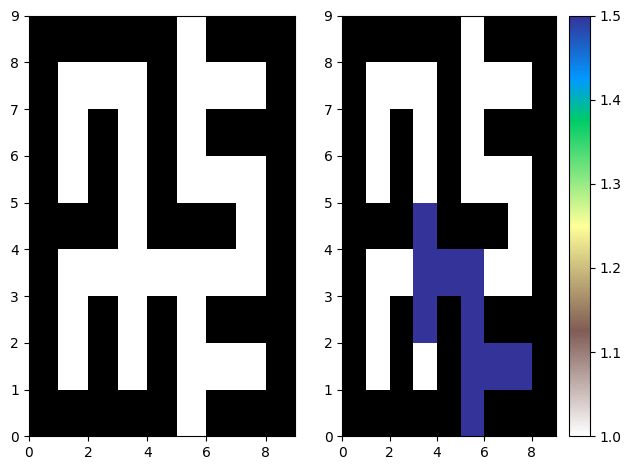

In [71]:
path = np.zeros(training_maze.squares.shape)
done = False
n_action = 0
env.reset()
path = np.zeros(training_maze.squares.shape)
path[env.agent_pos] = 0.5
while not done and n_action < 100:
    action = select_action(state, epsilon, model, action_size)
    next_state, reward, done = env.step(action)
    memory.append((state, action, reward, next_state, done))
    state = next_state
    total_reward += reward
    # train_from_memory(model, memory, batch_size, gamma, optimizer)
    n_action += 1
    # print(env.agent_pos, env.start, env.goal)
    path[env.agent_pos] = 0.5
training_maze = mz.Maze((9,9), 11)
training_maze.generate()
training_maze.squares[training_maze.squares != 0] = 1
plt.subplot(121)
training_maze.plot()
training_maze.squares += path
plt.subplot(122)
training_maze.plot()
plt.colorbar()


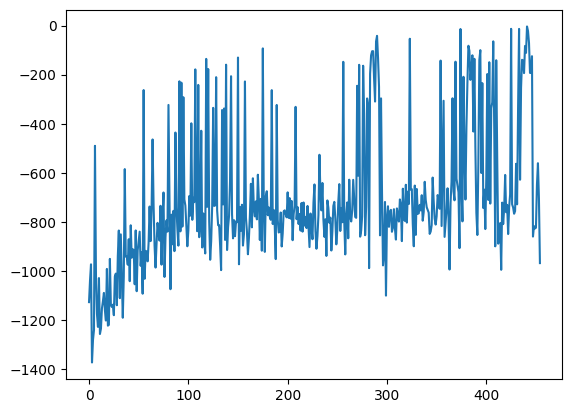

In [72]:
plt.plot(np.arange(len(rewards)), rewards)

In [73]:
print(n_done)

103
